[サブテーマ：レバナス（QLD）、TQQQの一括・積立シミュレーション]('https://note.com/note_kotakota/n/n9afbb9f3660e')

In [9]:
# TODO: Complete markdown

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語表示に対応


In [4]:
# 対象のティッカーシンボル
tickers = ['SPY', 'QQQ', 'QLD', 'TQQQ']

ticker_colors = {
    'SPY': 'red',
    'QQQ': 'green',
    'QLD': 'blue',
    'TQQQ': 'cyan'
}

# データの取得
data = yf.download(tickers, start="2010-03-01", end=pd.Timestamp.now().strftime('%Y-%m-%d'))
# 必要な列のみ抽出
data = data['Adj Close']
data

[*********************100%%**********************]  4 of 4 completed


,QLD,QQQ,SPY,TQQQ
Date,,,,
2010-03-01,1.782018,39.847015,85.756416,0.471539
2010-03-02,1.792758,39.969841,85.993988,0.474375
2010-03-03,1.797055,40.013737,86.070633,0.477008
2010-03-04,1.808410,40.145355,86.331230,0.482274
2010-03-05,1.861805,40.750832,87.565170,0.503593
...,...,...,...,...
2024-05-03,83.320000,435.480011,511.290009,56.700001
2024-05-06,85.180000,440.250000,516.570007,58.560001
2024-05-07,85.139999,440.320007,517.140015,58.560001


In [10]:
# 月次リターンを計算
monthly_returns = data.resample('M').ffill().pct_change()

# 月次リターンから年次リターンを計算（累積積を使用）
cumulative_annual_returns = (1 + monthly_returns).resample('A').prod() - 1

# 月次リターンの標準偏差を計算
monthly_std_devs = monthly_returns.std()

# 年率換算標準偏差は既に月次リターンに基づいているため、そのまま使用
annualized_std_devs_from_monthly = monthly_std_devs * np.sqrt(12)

# 結果をDataFrameに格納（累積積に基づく年次リターンを使用）
results = pd.DataFrame({
    "年次リターン": cumulative_annual_returns.median(),  # 年次リターンの中央値
    "月次リターンに基づく年率換算標準偏差": annualized_std_devs_from_monthly
})

results

,年次リターン,月次リターンに基づく年率換算標準偏差
QLD,0.347705,0.359137
QQQ,0.181125,0.175668
SPY,0.134638,0.147230
TQQQ,0.522872,0.547964


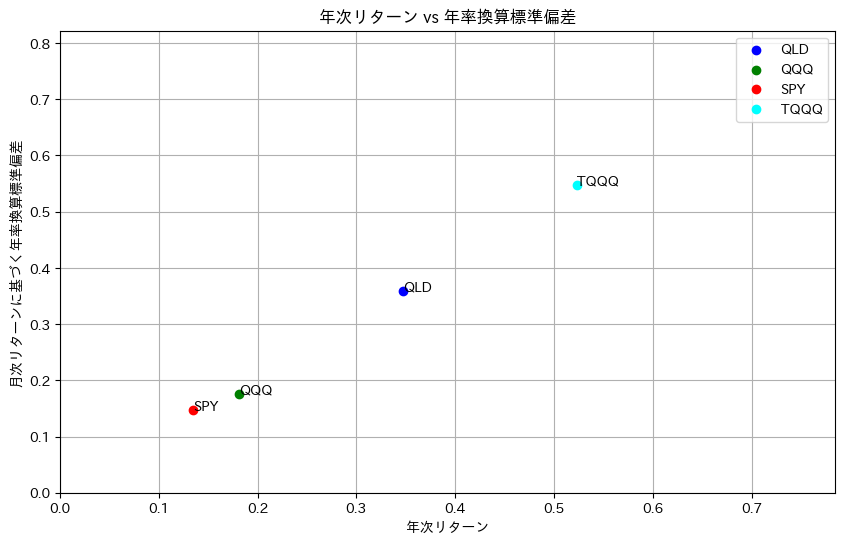

In [6]:
# 散布図をプロット
plt.figure(figsize=(10, 6))

# results DataFrameをループして、各ティッカーのポイントをプロット
for i, (index, row) in enumerate(results.iterrows()):
    # トレンドグラフで定義した色を使用
    color = ticker_colors.get(index, 'gray')  # ティッカーに色が割り当てられていない場合は'gray'を使用
    plt.scatter(row["年次リターン"], row["月次リターンに基づく年率換算標準偏差"], color=color, label=index)
    plt.annotate(index, (row["年次リターン"], row["月次リターンに基づく年率換算標準偏差"]))

# 軸のラベルを設定
plt.xlabel('年次リターン')
plt.ylabel('月次リターンに基づく年率換算標準偏差')

# 軸の範囲を設定
x_max = results["年次リターン"].max() * 1.5
y_max = results["月次リターンに基づく年率換算標準偏差"].max() * 1.5
plt.xlim(0, x_max)
plt.ylim(0, y_max)

# グラフのタイトルを設定
plt.title('年次リターン vs 年率換算標準偏差')

# グリッドを表示
plt.grid(True)

# 凡例を表示
plt.legend()

plt.show()

In [7]:
# パラメータ設定
initial_investment = 600  # 初期投資額
monthly_investment = 0  # 月次積立額
investment_duration = 60  # 投資期間（月）
simulations = 1000  # シミュレーション回数

# シミュレーションの実行と結果の収集
all_final_values = []

for ticker in tickers:
    # 既存のコードから月次リターンの平均と標準偏差を取得
    monthly_return_mean = monthly_returns[ticker].mean()
    monthly_return_std = monthly_std_devs[ticker]
    final_values = np.zeros(simulations)

    for simulation in range(simulations):
        total_value = initial_investment
        for month in range(investment_duration):
            monthly_return = np.random.normal(monthly_return_mean, monthly_return_std)
            total_value += monthly_investment
            total_value = total_value * (1 + monthly_return)
        final_values[simulation] = total_value
    all_final_values.append(final_values)

# 全シミュレーション結果からビンの範囲を決定するための配列を生成
flat_all_final_values = [value for sublist in all_final_values for value in sublist]
min_value = min(flat_all_final_values)
max_value = max(flat_all_final_values)
bins = np.linspace(min_value, max_value, 500)  # binsの数を500に設定

# 投資元本の計算（初期投資額 + 月次積立投資額の合計）
total_investment = initial_investment + monthly_investment * investment_duration
# x_maxをシミュレーション結果の最大値を基に設定
#x_max = max_value * 1.1  # 最大値の110%をX軸の最大値とする
x_max = total_investment*10

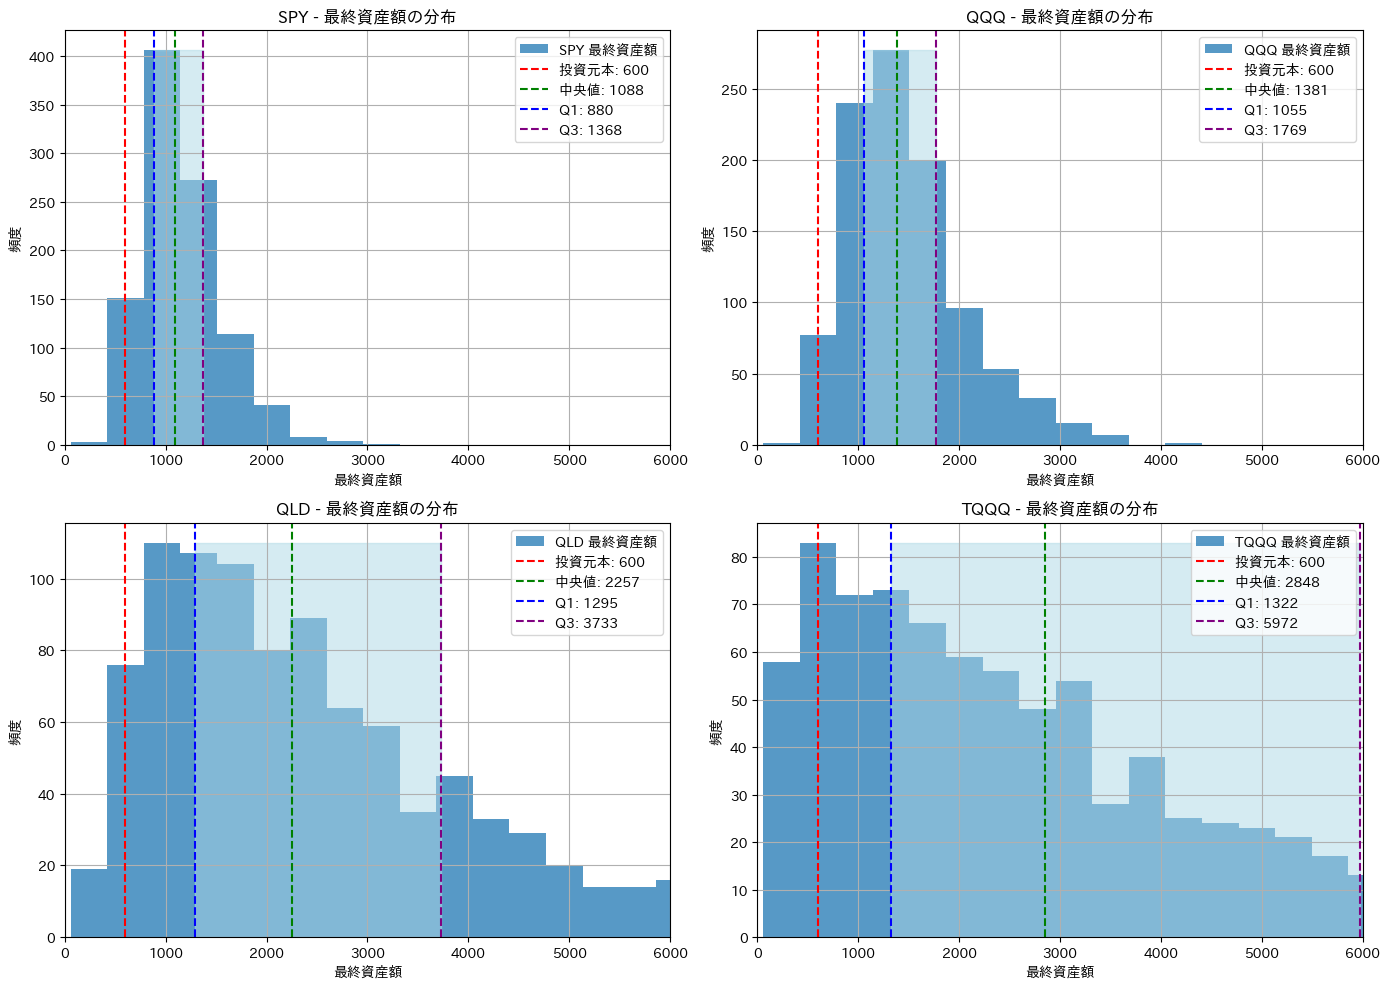

In [8]:
# 2x2のグリッドでサブプロットを作成し、X軸の範囲を設定
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    ax = axes[i]
    ticker_final_values = all_final_values[i]
    
    median_value = np.median(ticker_final_values)
    Q1 = np.percentile(ticker_final_values, 25)
    Q3 = np.percentile(ticker_final_values, 75)
    
    # ヒストグラムをプロット
    n, bins, patches = ax.hist(ticker_final_values, bins=bins, alpha=0.75, label=f'{ticker} 最終資産額')
    
    # Q1からQ3の間を透明な色で塗りつぶす
    ax.fill_betweenx([0, max(n)], Q1, Q3, color='lightblue', alpha=0.5)
    
    # 投資元本、中央値、Q1、Q3の線を追加
    ax.axvline(x=total_investment, color='r', linestyle='--', label=f'投資元本: {total_investment:.0f}')
    ax.axvline(x=median_value, color='green', linestyle='--', label=f'中央値: {median_value:.0f}')
    ax.axvline(x=Q1, color='blue', linestyle='--', label=f'Q1: {Q1:.0f}')
    ax.axvline(x=Q3, color='purple', linestyle='--', label=f'Q3: {Q3:.0f}')

    ax.set_title(f'{ticker} - 最終資産額の分布')
    ax.set_xlabel('最終資産額')
    ax.set_ylabel('頻度')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0, x_max)

plt.tight_layout()
plt.show()